<a href="https://colab.research.google.com/github/catherine-somers/Capstone-2--Springboard/blob/master/CP2_Sentiment_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 16.0MB/s 
     |████████████████████████████████| 890kB 33.2MB/s 
     |████████████████████████████████| 1.1MB 24.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=980021f9bdaffa357b8e92a0dd5970223d049ead9fa5e28323d6136def7ed4f0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
import pandas as pd
import numpy as np
import nltk
from tqdm.notebook import tqdm

In [3]:
review_data = [line.rstrip() for line in open('amazon_alexa.tsv')]
print (len(review_data))

3151


In [4]:
review_data = pd.read_csv("amazon_alexa.tsv",sep="\t")
review_data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
review_data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [6]:
review_data.groupby('rating').describe()

feedback                                   
          count mean  std  min  25%  50%  75%  max
rating                                            
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [7]:
review_data['length'] = review_data['verified_reviews'].apply(len)
review_data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [8]:
review_data.describe()

,rating,feedback,length
count,3150.000000,3150.000000,3150.000000
mean,4.463175,0.918413,132.049524
std,1.068506,0.273778,182.099952
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,165.000000
max,5.000000,1.000000,2851.000000


In [9]:
review_data.groupby('rating').describe()

feedback                      ... length                              
          count mean  std  min  25%  ...    min    25%    50%     75%     max
rating                               ...                                     
1         161.0  0.0  0.0  0.0  0.0  ...    1.0  36.00  120.0  284.00  1124.0
2          96.0  0.0  0.0  0.0  0.0  ...    1.0  78.75  163.0  309.25  1686.0
3         152.0  1.0  0.0  1.0  1.0  ...    1.0  54.00  130.0  284.00  1954.0
4         455.0  1.0  0.0  1.0  1.0  ...    1.0  34.00   99.0  241.00  1360.0
5        2286.0  1.0  0.0  1.0  1.0  ...    1.0  26.00   64.0  135.00  2851.0

[5 rows x 16 columns]

In [10]:
review_data['length'] = review_data['verified_reviews'].apply(len)
review_data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


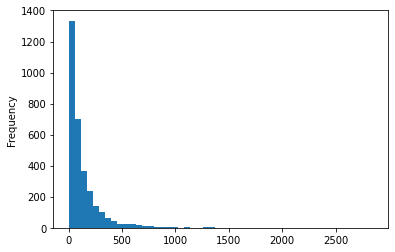

In [12]:
review_data['length'].plot(bins=50, kind='hist')

The Maximum length review

In [13]:
review_data.length.describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

A 2851 characters long review, let's use masking to find this message:

In [14]:
review_data[review_data['length'] == 2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

Let's try to see if review length is a distinguishing feature between positive and negative review:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f3cf76da0>,
      dtype=object)

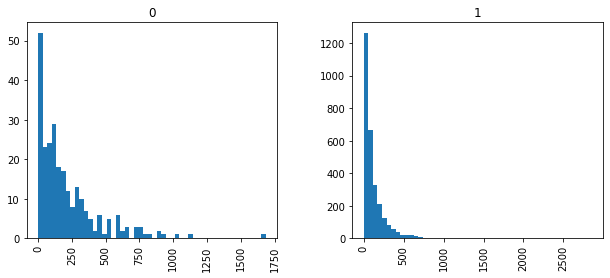

In [15]:
review_data.hist(column='length', by='feedback', bins=50,figsize=(10,4))

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Importing the dataset
dataset = pd.read_csv('amazon_alexa.tsv', delimiter = '\t', quoting = 3)

In [18]:
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus=[]
for i in range(0,3150):
    review = re.sub('[^a-zA-Z]', ' ', dataset['verified_reviews'][i] )
    review=review.lower()
    review=review.split()
    ps=PorterStemmer()
    review=[ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# creating the Bag of words Model
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(corpus).toarray()
y=dataset.iloc[:,4].values

In [20]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [21]:
import xgboost as xgb

# Fitting Random Forest classifier with 100 trees to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [23]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 12,  42],
       [  0, 576]])

In [24]:
print('True positive = ', cm[0][0])
print('False positive = ', cm[0][1])
print('False negative = ', cm[1][0])
print('True negative = ', cm[1][1])

True positive =  12
False positive =  42
False negative =  0
True negative =  576


In [25]:
possible_labels = review_data.feedback.unique()

In [26]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [27]:
review_data['label'] = review_data.feedback.replace(label_dict)

In [28]:
review_data.head()

,rating,date,variation,verified_reviews,feedback,length,label
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,0
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,0
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195,0
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172,0
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,0


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(review_data.index.values, 
                                                  review_data.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  )

In [31]:
review_data['data_type'] = ['not_set']*review_data.shape[0]

In [32]:
review_data.loc[X_train, 'data_type'] = 'train'
review_data.loc[X_val, 'data_type'] = 'val'

In [33]:
review_data.groupby(['feedback', 'label', 'data_type']).count()

rating  date  variation  verified_reviews  length
feedback label data_type                                                   
0        1     train         212   212        212               212     212
               val            45    45         45                45      45
1        0     train        2465  2465       2465              2465    2465
               val           428   428        428               428     428

## Loading Tokenizer and Encoding our Data

In [34]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [36]:
encoded_data_train = tokenizer.batch_encode_plus(
    review_data[review_data.data_type=='train'].verified_reviews.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    review_data[review_data.data_type=='val'].verified_reviews.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(review_data[review_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(review_data[review_data.data_type=='val'].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train)

In [39]:
len(dataset_val)

473

In [40]:
from transformers import BertForSequenceClassification

In [41]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [42]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [43]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [44]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [45]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [46]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [47]:
import numpy as np
from sklearn.metrics import f1_score

In [48]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [49]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [50]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [52]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [53]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), 'review_bert.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.3148816673173791
Validation loss: 0.2475998193025589
F1 Score (Weighted): 0.8596696646666964



Epoch 2
Training loss: 0.17262490617022627
Validation loss: 0.16982717762390773
F1 Score (Weighted): 0.8945034872660276



Epoch 3
Training loss: 0.12063184564578391
Validation loss: 0.15787819772958755
F1 Score (Weighted): 0.9300933676683805



In [54]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [55]:
model.load_state_dict(
    torch.load('review_bert.model',
        map_location=torch.device('cpu')))

<All keys matched successfully>

In [56]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [57]:
accuracy_per_class(predictions, true_vals)

Class: 1
Accuracy: 424/428

Class: 0
Accuracy: 20/45

